### Training Script for Accelerometer Dataset using Bidirectional LSTM Architecture 

@ Author : Niloy Chakraborty

@ Author Contact: chakrabortyniloy2018@gmail.com

In [ ]:
# Connect to Google Colab.  If using Jupyter, then comment this part
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/THESIS/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/THESIS


#### Load the Libraries

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
# import tensorflow_addons as tfa


In [ ]:
import os
import yaml

import tensorflow as tf

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM, Dropout,Dense,RepeatVector,TimeDistributed,Input,BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam as adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import load_model

#### Load and Explore the training Dataset

In [ ]:
Category = "Acc_5_Class_BiLSTM"

In [ ]:
filepath = 'Acc_25_secs_final_combined_faulty_data_train.csv'

In [ ]:
import tensorflow as tf
tf.version.VERSIONheader = ['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','Altitude','Cmd1','Cmd2','Cmd3','Cmd4','Roll','Pitch','Yaw','ThurstRefOut1','ThurstRefOut2','ThurstRefOut3','ThurstRefOut4','Label']

In [ ]:
df = pd.read_csv(filepath, header = None)
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.iloc[:, 1:]
df["Label"] = pd.to_numeric(df["Label"])
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Altitude,Cmd1,Cmd2,Cmd3,Cmd4,Roll,Pitch,Yaw,ThurstRefOut1,ThurstRefOut2,ThurstRefOut3,ThurstRefOut4,Label
1,0.03380774,-0.11192460000000001,-9.492839,-0.0098925,-0.007933972,0.00108462,0.44,342.9332,-342.9577,342.8969,-342.9631,-1.965233e-06,-2.155978e-06,-5.859605e-07,-0.22403289999999998,-0.2240489,-0.22400920000000002,-0.22405239999999998,0
2,-0.116923,-0.2512355,-14.08014,-0.01084344,-0.009036063,-2.253169e-05,0.44,343.0175,-342.912,342.8928,-342.9287,-4.02452e-06,-4.6669999999999995e-06,-7.215308e-08,-0.224088,-0.224019,-0.2240065,-0.22403,0
3,0.22785189999999997,0.06732436,-13.62979,-0.008328836,-0.006301623,0.0025199379999999998,0.44,342.9608,-342.8717,343.0659,-342.8525,6.818334e-06,7.100436999999999e-06,5.960543e-07,-0.2240509,-0.2239928,-0.2241196,-0.22398020000000002,0
4,-0.01241245,-0.1545401,-13.94356,-0.01056849,-0.008493732,0.0007364108,0.44,342.8445,-343.066,342.7531,-343.0873,-3.975494e-06,-3.691068e-06,1.940148e-06,-0.223975,-0.2241197,-0.22391529999999998,-0.22413360000000002,0
5,0.21535289999999999,0.05578018,-13.64611,-0.008419157,-0.006429253,0.00240215,0.44,343.4182,-342.416,343.5187,-342.3979,1.696333e-05,1.88649e-05,1.3310810000000002e-05,-0.22434980000000002,-0.2236951,-0.2244154,-0.2236833,0


In [ ]:
df.columns

Index(['AccX', 'AccY', 'AccZ', 'GyrX', 'GyrY', 'GyrZ', 'Altitude', 'Cmd1',
       'Cmd2', 'Cmd3', 'Cmd4', 'Roll', 'Pitch', 'Yaw', 'ThurstRefOut1',
       'ThurstRefOut2', 'ThurstRefOut3', 'ThurstRefOut4', 'Label'],
      dtype='object')

In [ ]:
df.shape

(3177500, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3177500 entries, 1 to 3177500
Data columns (total 19 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   AccX           object
 1   AccY           object
 2   AccZ           object
 3   GyrX           object
 4   GyrY           object
 5   GyrZ           object
 6   Altitude       object
 7   Cmd1           object
 8   Cmd2           object
 9   Cmd3           object
 10  Cmd4           object
 11  Roll           object
 12  Pitch          object
 13  Yaw            object
 14  ThurstRefOut1  object
 15  ThurstRefOut2  object
 16  ThurstRefOut3  object
 17  ThurstRefOut4  object
 18  Label          int64 
dtypes: int64(1), object(18)
memory usage: 484.8+ MB


In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

In [ ]:
# Convert data to numeric type
df = df.apply(pd.to_numeric)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3177500 entries, 1 to 3177500
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AccX           float64
 1   AccY           float64
 2   AccZ           float64
 3   GyrX           float64
 4   GyrY           float64
 5   GyrZ           float64
 6   Altitude       float64
 7   Cmd1           float64
 8   Cmd2           float64
 9   Cmd3           float64
 10  Cmd4           float64
 11  Roll           float64
 12  Pitch          float64
 13  Yaw            float64
 14  ThurstRefOut1  float64
 15  ThurstRefOut2  float64
 16  ThurstRefOut3  float64
 17  ThurstRefOut4  float64
 18  Label          int64  
dtypes: float64(18), int64(1)
memory usage: 484.8 MB


In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

### Data Preprocessing 

#### Feature Selection

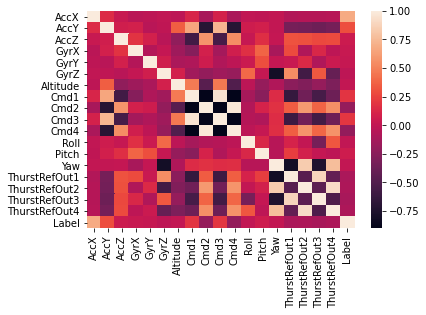

In [ ]:
import seaborn as sns

sns.heatmap(df.corr())
plt.show()

In [ ]:
new_cols = ["AccX","AccY","Cmd1","Cmd3","Label"]

In [ ]:
df = df[new_cols]

In [ ]:
df.shape

(3177500, 5)

In [ ]:
df["Label"].value_counts()

0    1936680
1     313100
2     310928
3     309983
4     306809
Name: Label, dtype: int64

In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

In [ ]:
y = df["Label"]
X = df.drop("Label",axis= 1)

#### Data Normalization

In [ ]:

from sklearn.preprocessing import RobustScaler
new_cols = ["AccX","AccY","Cmd1","Cmd3"]
scale_columns = new_cols

scaler = RobustScaler()

scaler = scaler.fit(X[scale_columns])

X.loc[:, scale_columns] = scaler.transform(X[scale_columns].to_numpy())


#### Creating Sliding Windows

In [ ]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    X[new_cols], 
    y, 
    TIME_STEPS, 
    STEP
)

In [ ]:
print(X_train.shape, y_train.shape)


(79433, 200, 4) (79433, 1)


In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 49122]
 [    1  7654]
 [    2  7598]
 [    3  7573]
 [    4  7486]]


#### Label Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
# y_test = enc.transform(y_test)

In [ ]:
print(X_train.shape, y_train.shape)


(79433, 200, 4) (79433, 5)


### Building BiLSTM Architecture

In [ ]:
from tensorflow import keras

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
def plot_training(history):
    print(history.history.keys())

    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Training

Epoch 1/50
993/993 [==============================] - 29s 26ms/step - loss: 0.7394 - acc: 0.7402 - val_loss: 0.5882 - val_acc: 0.8363
Epoch 2/50
993/993 [==============================] - 25s 26ms/step - loss: 0.4565 - acc: 0.8327 - val_loss: 0.5520 - val_acc: 0.8606
Epoch 3/50
993/993 [==============================] - 25s 25ms/step - loss: 0.4029 - acc: 0.8484 - val_loss: 0.5268 - val_acc: 0.8613
Epoch 4/50
993/993 [==============================] - 25s 25ms/step - loss: 0.3841 - acc: 0.8539 - val_loss: 0.5107 - val_acc: 0.8741
Epoch 5/50
993/993 [==============================] - 25s 25ms/step - loss: 0.3729 - acc: 0.8576 - val_loss: 0.4935 - val_acc: 0.8793
Epoch 6/50
993/993 [==============================] - 25s 26ms/step - loss: 0.3550 - acc: 0.8642 - val_loss: 0.6002 - val_acc: 0.8618
Epoch 7/50
993/993 [==============================] - 25s 26ms/step - loss: 0.3438 - acc: 0.8684 - val_loss: 0.4650 - val_acc: 0.8839
Epoch 8/50
993/993 [==============================] - 25s 25ms

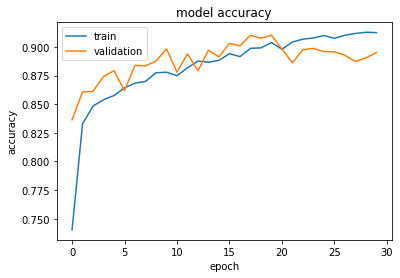

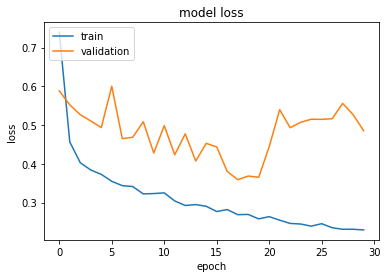

In [ ]:
def training(model, X_train, y_train):
    # Another control put in place to handle overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',verbose=1,patience=10,mode='max',restore_best_weights=True)

    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    
    # compile the model
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['acc']) 

    # Training
    history = model.fit(X_train, y_train,epochs=50,batch_size=64,validation_split=0.2,shuffle=True,callbacks=[early_stopping])

    # plot training performance over the epochs
    plot_training(history)

training(model, X_train, y_train)

### Save the Model

In [ ]:
import datetime
model.save("Acc_Models/"+Category+ f'{datetime.datetime.today().strftime("%d-%m-%Y %H:%M")}.h5')